# 4. Implement an Optimization!

In [1]:
import numpy as np
import pandas as pd

In [3]:
ret = pd.read_csv("data/data4_industry_30_vw_monthly.csv",
                 header=0, index_col=0)/100  
ret.index=pd.to_datetime(ret.index,format="%Y%m").to_period("m")
ret.columns=ret.columns.str.strip()
#ret.head(3)

In [4]:
n_years=ret["1992":].shape[0]/12 #number of months/12
eret=((1+ret["1992":]).prod())**(1/n_years)-1 #annualized expected returns
cov=ret["1992":].cov()*12 #.cov() covariance matrix monthly*12--> annualized covariance

l=["Food","Beer","Smoke","Games"]
eret[l]
cov.loc[l,l]

,Food,Beer,Smoke,Games
Food,0.017245,0.013844,0.016109,0.014420
Beer,0.013844,0.025237,0.013000,0.012797
Smoke,0.016109,0.013000,0.053180,0.013268
Games,0.014420,0.012797,0.013268,0.056781


In [5]:
#build functions for portfolio returns and portfolio volatility
def portfolio_ret(weights, returns):
    return weights.T@returns    

In [6]:
def portfolio_vol(weights,covmat):
    return (weights.T@covmat@weights)**.5 #or use np.sqrt()

In [7]:
from scipy.optimize import minimize #readily available function to minimize in an optimization

In [8]:
def minimize_vol(target_return,ereturns,covmat):
    """
    target return--> weights in a minimum-variance portfolio that generates target return
    """
    n=ereturns.shape[0] #number of assets
    init_values=np.repeat(1/n,n) #an array of numbers
    
    bounds=((0,1),)*n  #an array on n elements(tuples)  0<each weights<1
    
    #Constraints:
    weights_sum_to_1={'type':'eq',
                     'fun':lambda weights:np.sum(weights)-1}
    return_is_target={'type':'eq',
                     'args':(ereturns,),
                     'fun':lambda weights,ereturns: portfolio_ret(weights,ereturns)-target_return}
    
    results=minimize(portfolio_vol,
                    init_values,
                    args=(covmat),
                    method='SLSQP',   #Sequential least Squares of quadratic problems?
                    bounds=bounds,
                    constraints=(weights_sum_to_1,return_is_target),
                    options={'disp':False}) 
    weights=results.x  #The solution(output)
    return weights
    

In [9]:
l=["Games","Beer"]
w11=minimize_vol(0.11,eret[l],cov.loc[l,l])
w11

array([0.37177817, 0.62822183])

In [10]:
portfolio_ret(w11,eret[l])

0.11000000004810469

In [11]:
portfolio_vol(w11,cov.loc[l,l])

0.15422631467144549

In [12]:
def optimal_weights(n_points,ereturns,covmat):
    """
    takes expected returns and vols + # of gridpoints--> weights of the efficient frontier portfolio
    """
    target_returns=np.linspace(ereturns.min(),ereturns.max(),n_points)
    optimal_weights=[minimize_vol(tr,ereturns,covmat) for tr in target_returns]
    
    return optimal_weights

<Axes: xlabel='V'>

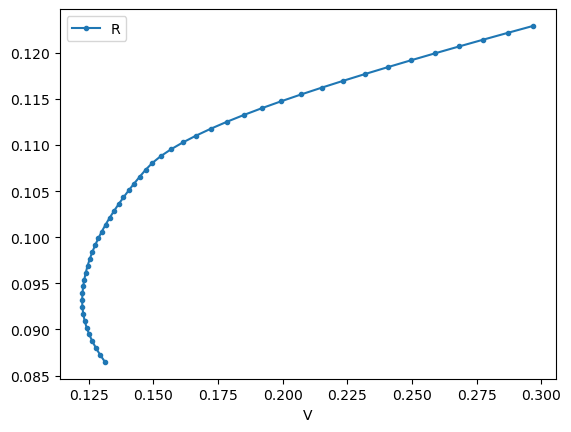

In [14]:
l=["Food","Fin","Hlth","Autos"]
efweights=optimal_weights(50,eret[l],cov.loc[l,l])
pret=[portfolio_ret(w,eret[l]) for w in efweights]
pvol=[portfolio_vol(w,cov.loc[l,l]) for w in efweights]

ef=pd.DataFrame({"R": pret,
               "V": pvol})
ef.plot.line(x="V",y="R",style=".-")